In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import pandas as pd

import seaborn as sns
import sys
import click
import os
# import warnings
warnings.filterwarnings(
    "ignore", message="divide by zero", category=RuntimeWarning
)
from yammbs import analysis,MoleculeStore
from openff.toolkit import Molecule
from openff.units import unit

# Importing/cleaning data

In [2]:
# Need to re-calculate DDE--old benchmark uses 5e-9 cutoff but wrong DDE def, new uses 10 cutoff and correct ddE def
# Need to compare 5e-9 + new ddE def. So re-calculate the dde from the old sqlite using the new version of yammbs.

# store = MoleculeStore('../sage-2.2.0/05_benchmark_forcefield_oldscript/openff_unconstrained-2.1.0.sqlite')
# yammbs_dde = store.get_dde(force_field = 'openff_unconstrained-2.1.0.offxml',skip_check=True)
# yammbs_dde.to_csv('openff_unconstrained-2.1.0/dde_ogdef.csv')

In [3]:
# All of these were generated using the optimization settings that are the same as the OG benchmarks--force cutoff of 5e-9
yammbs_dde = pd.read_csv('./openff_unconstrained-2.1.0/dde_ogdef.csv')
yammbs_rmsd = pd.read_csv('./openff_unconstrained-2.1.0/rmsd.csv') # YAMMBS uses heavy-atom only RMSD, OG BM uses all-atom
yammbs_rmsd_aa = pd.read_csv('./openff_unconstrained-2.1.0/rmsd_allatom.csv') # Re-do YAMMBS RMSD but switched off heavy atom only. This also uses the new molecule from smiles fix
yammbs_tfd = pd.read_csv('./openff_unconstrained-2.1.0/tfd.csv') # Initial TFD, with molecules from InChI
yammbs_tfd_smiles = pd.read_csv('./openff_unconstrained-2.1.0/tfd_smiles.csv') 

In [4]:
yammbs_dde = yammbs_dde.set_index('Unnamed: 0')
yammbs_rmsd = yammbs_rmsd.set_index('Unnamed: 0')
yammbs_rmsd_aa = yammbs_rmsd_aa.set_index('Unnamed: 0')
yammbs_tfd = yammbs_tfd.set_index('Unnamed: 0')
yammbs_tfd_smiles = yammbs_tfd_smiles.set_index('Unnamed: 0')

In [5]:
# This is from Pavan's Sage 2.2.0 repo--but he benchmarked Sage 2.1.0
sage_ogbm = pd.read_csv('03-metrics.csv')
sage_210_ogbm = sage_ogbm.loc[sage_ogbm['Force Field'] == 'Sage 2.1.0']

In [6]:
sage_210_ogbm_dde = sage_210_ogbm[['Record ID','ddE']]
sage_210_ogbm_rmsd = sage_210_ogbm[['Record ID','RMSD']]
sage_210_ogbm_tfd = sage_210_ogbm[['Record ID','TFD']]

In [7]:
sage_210_ogbm_dde = sage_210_ogbm_dde.set_index('Record ID')
sage_210_ogbm_rmsd = sage_210_ogbm_rmsd.set_index('Record ID')
sage_210_ogbm_tfd = sage_210_ogbm_tfd.set_index('Record ID')

In [8]:
# Only compare records that are in both benchmarks
yammbs_dde_inog = yammbs_dde.loc[yammbs_dde.index.isin( list(sage_210_ogbm_dde.index))]
yammbs_rmsd_inog = yammbs_rmsd.loc[yammbs_rmsd.index.isin( list(sage_210_ogbm_rmsd.index))]
yammbs_rmsd_aa_inog = yammbs_rmsd_aa.loc[yammbs_rmsd_aa.index.isin( list(sage_210_ogbm_rmsd.index))]
yammbs_tfd_inog = yammbs_tfd.loc[yammbs_tfd.index.isin( list(sage_210_ogbm_tfd.index))]
yammbs_tfd_smiles_inog = yammbs_tfd_smiles.loc[yammbs_tfd_smiles.index.isin( list(sage_210_ogbm_tfd.index))]

In [9]:
sage_210_ogbm_dde_inym = sage_210_ogbm_dde.loc[sage_210_ogbm_dde.index.isin( list(yammbs_dde.index))]
sage_210_ogbm_rmsd_inym = sage_210_ogbm_rmsd.loc[sage_210_ogbm_rmsd.index.isin( list(yammbs_rmsd.index))]
sage_210_ogbm_tfd_inym = sage_210_ogbm_tfd.loc[sage_210_ogbm_tfd.index.isin( list(yammbs_tfd.index))]

# DDE

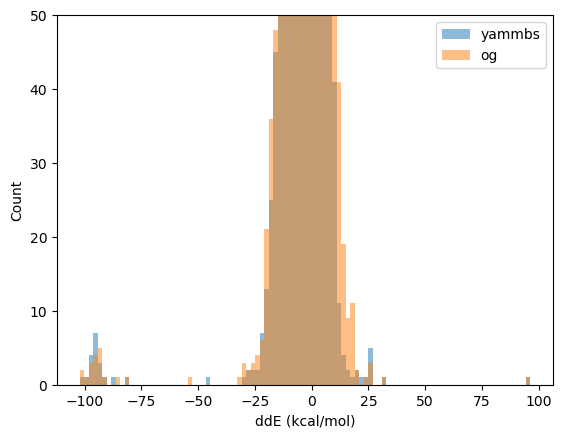

In [10]:
plt.figure()
plt.hist(yammbs_dde_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_dde_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,50)
plt.legend()
plt.ylabel('Count')
plt.xlabel('ddE (kcal/mol)')
plt.savefig('figures/dde_zoom.jpg')
plt.show()

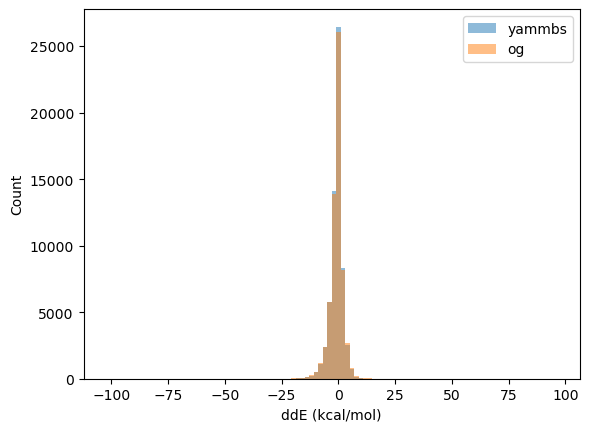

In [11]:
plt.figure()
plt.hist(yammbs_dde_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_dde_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,50)
plt.legend()
plt.ylabel('Count')
plt.xlabel('ddE (kcal/mol)')
plt.savefig('figures/dde.jpg')
plt.show()

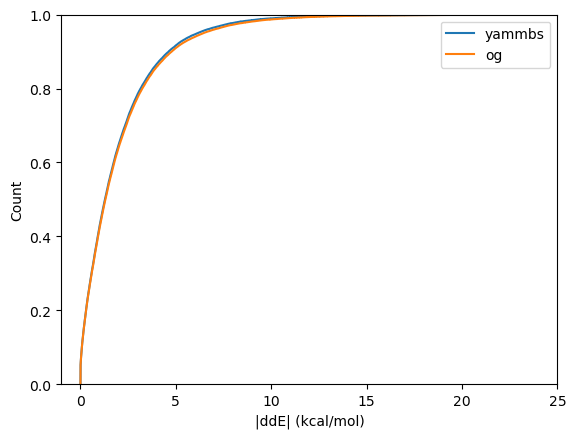

In [12]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_dde_inog.dropna()['difference']),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_dde_inym.dropna()['ddE']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-1,25)
ax.legend()
ax.set_ylabel('Count')
ax.set_xlabel('|ddE| (kcal/mol)')
plt.savefig('figures/dde_ecdf.jpg')
plt.show()

~I suspect that the OG benchmarks were not using the unconstrained FF. May be source of discrepency?~ These were run by calling the constrained FF but deregistering constraints. Code looks identical for calculating DDE and for minimizing molecule, unless using the interchange to create the "system" could cause an issue. The code looks like it's just doing the same thing under the hood?

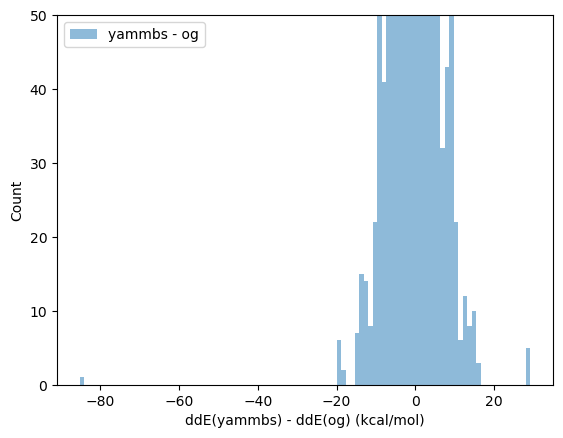

In [13]:
plt.figure()
plt.hist(yammbs_dde_inog['difference'].dropna()-sage_210_ogbm_dde_inym['ddE'].dropna(),label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_dde_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,50)
plt.legend()
plt.ylabel('Count')
plt.xlabel('ddE(yammbs) - ddE(og) (kcal/mol)')
plt.savefig('figures/dde_dif.jpg')
plt.show()

In [14]:
dde_bigdif = (yammbs_dde_inog['difference'].dropna()-sage_210_ogbm_dde_inym['ddE'].dropna()).loc[np.abs(yammbs_dde_inog['difference'].dropna()-sage_210_ogbm_dde_inym['ddE'].dropna()) > 5]

In [15]:
dde_bigdif

36955003   -19.270712
36955004   -19.408647
36955006   -17.900922
36955008   -17.900922
36955075    -5.105541
              ...    
43431985     7.124609
43431994     6.314276
43432222     5.099596
43432371    -9.051682
43432373    -9.051682
Length: 564, dtype: float64

# RMSD

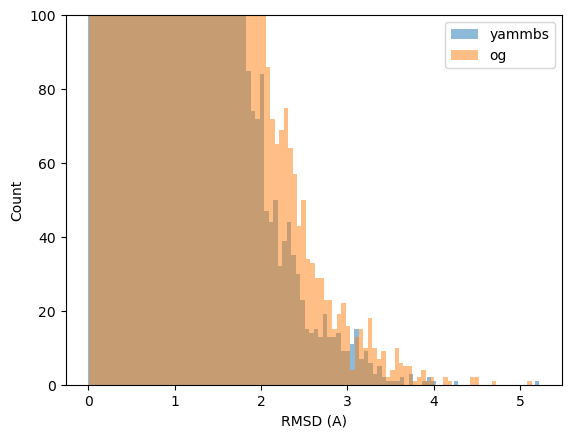

In [16]:
plt.figure()
plt.hist(yammbs_rmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_rmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('RMSD (A)')
plt.ylabel('Count')
plt.savefig('figures/rmsd_yammbsheavy_ogallatom_zoom.jpg')
plt.show()

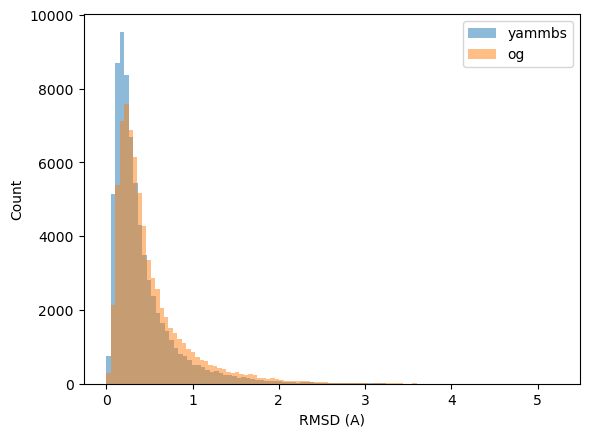

In [17]:
plt.figure()
plt.hist(yammbs_rmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_rmsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('RMSD (A)')
plt.ylabel('Count')
plt.savefig('figures/rmsd_yammbsheavy_ogallatom.jpg')
plt.show()

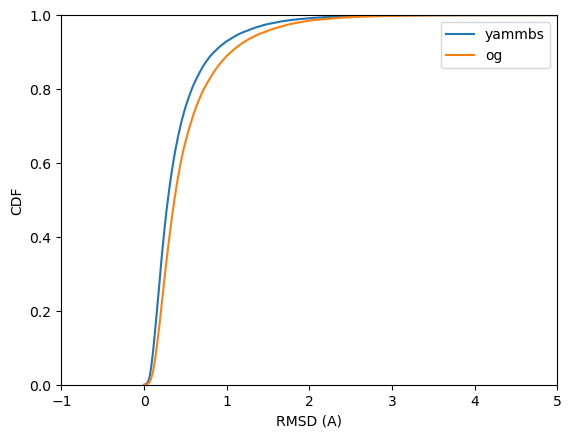

In [18]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_rmsd_inog.dropna()['rmsd']),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_rmsd_inym.dropna()['RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-1,5)
ax.legend()
ax.set_ylabel('CDF')
ax.set_xlabel('RMSD (A)')
plt.savefig('figures/rmsd_yammbsheavy_ogallatom_ecdf.jpg')
plt.show()

Original used hydrogens for RMSD, yammbs uses heavy atoms only. Re-check?

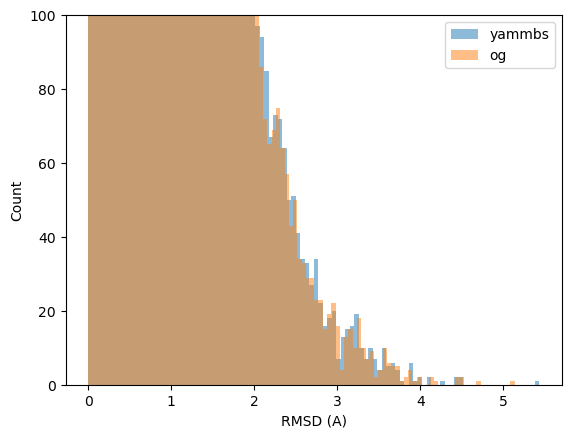

In [19]:
plt.figure()
plt.hist(yammbs_rmsd_aa_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_rmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('RMSD (A)')
plt.ylabel('Count')
plt.savefig('figures/rmsd_bothallatom_zoom.jpg')
plt.show()

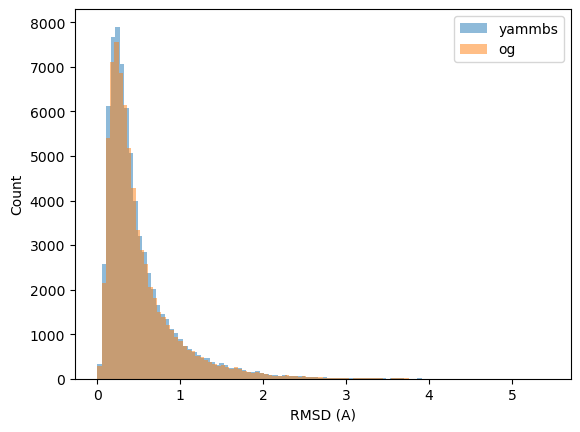

In [20]:
plt.figure()
plt.hist(yammbs_rmsd_aa_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_rmsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('RMSD (A)')
plt.ylabel('Count')
plt.savefig('figures/rmsd_bothallatom.jpg')
plt.show()

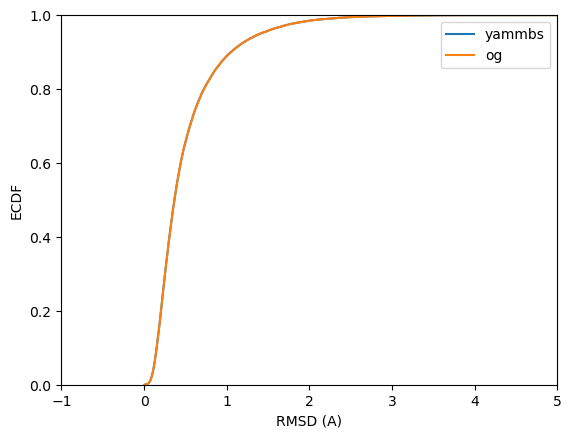

In [21]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_rmsd_aa_inog.dropna()['rmsd']),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_rmsd_inym.dropna()['RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-1,5)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('RMSD (A)')
plt.savefig('figures/rmsd_bothallatom_ecdf.jpg')
plt.show()

Yeah they're the same with the all atom RMSD

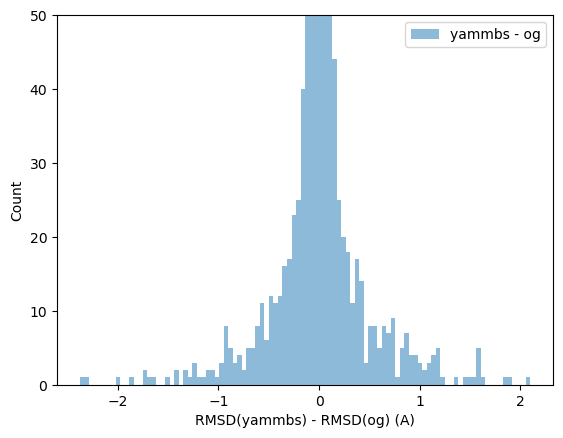

In [22]:
plt.figure()
plt.hist(yammbs_rmsd_aa_inog['rmsd'].dropna()-sage_210_ogbm_rmsd_inym['RMSD'].dropna(),label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_dde_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,50)
plt.legend()
plt.ylabel('Count')
plt.xlabel('RMSD(yammbs) - RMSD(og) (A)')
plt.savefig('figures/rmsd_aa_dif.jpg')
plt.show()

In [216]:
rmsd_bigdif = (yammbs_rmsd_aa_inog['rmsd'].dropna()-sage_210_ogbm_rmsd_inym['RMSD'].dropna()).loc[np.abs(yammbs_rmsd_aa_inog['rmsd'].dropna()-sage_210_ogbm_rmsd_inym['RMSD'].dropna()) > 0.4]

In [217]:
rmsd_bigdif

36955075    1.606699
36955199   -1.400556
36955355   -0.694259
36955639    0.713151
36955850    0.545219
              ...   
43430024    1.513632
43431603    1.460810
43431640   -0.607373
43431994   -1.714306
43432393    0.454866
Length: 222, dtype: float64

In [218]:
from yammbs.analysis import RMSDCollection,RMSD
# Code used to generate new RMSD
# copied from yammbs, but turned off heavy atom only flag
def get_rmsd(
    molecule,
    reference,
    target,
):
    """Compute the RMSD between two sets of coordinates."""
    from openeye import oechem
    from openff.units import Quantity, unit

    molecule1 = Molecule(molecule)
    molecule2 = Molecule(molecule)

    for molecule in (molecule1, molecule2):
        if molecule.conformers is not None:
            molecule.conformers.clear()

    molecule1.add_conformer(Quantity(reference, unit.angstrom))

    molecule2.add_conformer(Quantity(target, unit.angstrom))

    # oechem appears to not support named arguments, but it's hard to tell
    # since the Python API is not documented
    return oechem.OERMSD(
        molecule1.to_openeye(),
        molecule2.to_openeye(),
        True,
        False, # heavy atom only = False
        True,
    )


# copied from yammbs
def get_rmsd_store(
    store,
    force_field,
    skip_check,
):
    # if not skip_check:
    #     store.optimize_mm(force_field=force_field)

    rmsds = RMSDCollection()

    for inchi_key in store.get_inchi_keys():
        molecule = Molecule.from_inchi(inchi_key, allow_undefined_stereo=True)
        molecule_id = store.get_molecule_id_by_inchi_key(inchi_key)

        qcarchive_ids = store.get_qcarchive_ids_by_molecule_id(molecule_id)

        qm_conformers = store.get_qm_conformers_by_molecule_id(molecule_id)
        mm_conformers = store.get_mm_conformers_by_molecule_id(
            molecule_id,
            force_field,
        )

        for qm, mm, id in zip(
            qm_conformers,
            mm_conformers,
            qcarchive_ids,
        ):
            rmsds.append(
                RMSD(
                    qcarchive_id=id,
                    rmsd=get_rmsd(molecule, qm, mm),
                    force_field=force_field,
                ),
            )

    return rmsds

In [219]:
# ran this on hpc3
# rmsds_noheavy = get_rmsd_store(store,'openff_unconstrained-2.1.0.offxml',True)

# TFD
Plotting--run with yammbs_smiles

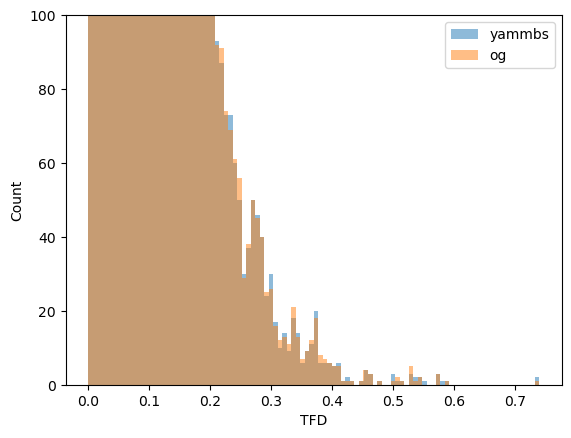

In [220]:
plt.figure()
plt.hist(yammbs_tfd_smiles_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_tfd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('TFD')
plt.ylabel('Count')
plt.savefig('figures/tfd_smiles_zoom.jpg')
plt.show()

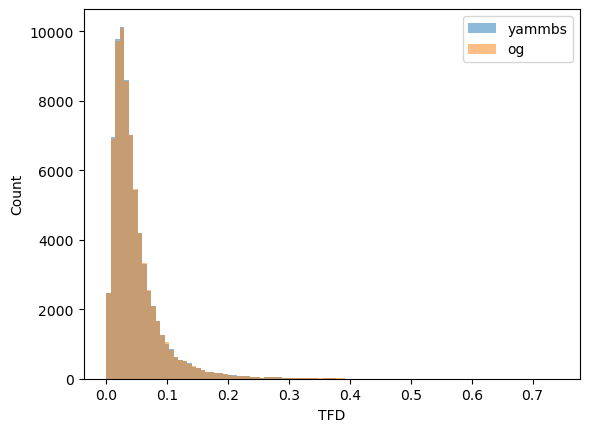

In [221]:
plt.figure()
plt.hist(yammbs_tfd_smiles_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_tfd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('TFD')
plt.ylabel('Count')
plt.savefig('figures/tfd_smiles.jpg')
plt.show()

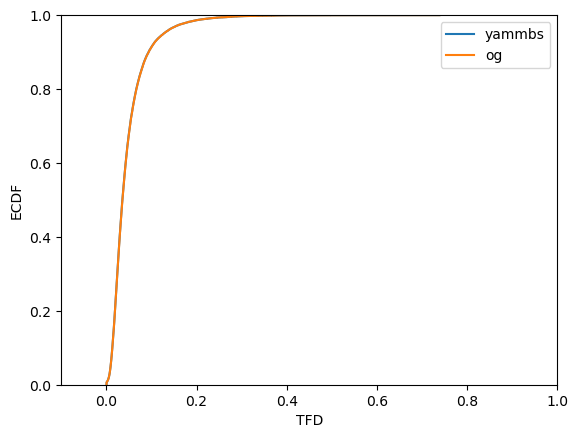

In [222]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_tfd_smiles_inog.dropna()['tfd']),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_tfd_inym.dropna()['TFD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-.1,1)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('TFD')
plt.savefig('figures/tfd_smiles_ecdf.jpg')
plt.show()

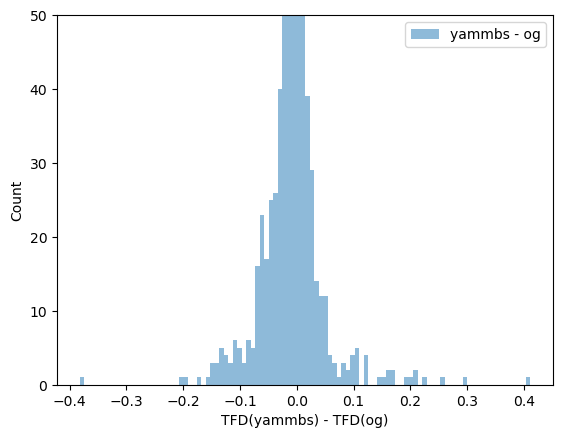

In [277]:
plt.figure()
plt.hist(yammbs_tfd_smiles_inog['tfd'].dropna()-sage_210_ogbm_tfd_inym['TFD'].dropna(),label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_dde_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,50)
plt.legend()
plt.ylabel('Count')
plt.xlabel('TFD(yammbs) - TFD(og)')
plt.savefig('figures/tfd_smiles_dif.jpg')
plt.show()

In [284]:
tfd_bigdif = (yammbs_tfd_smiles_inog['tfd'].dropna()-sage_210_ogbm_tfd_inym['TFD'].dropna()).loc[np.abs(yammbs_tfd_smiles_inog['tfd'].dropna()-sage_210_ogbm_tfd_inym['TFD'].dropna()) > 0.1].sort_index()

non-overlapping groups for the most part...

# ICRMSD

In [225]:
yammbs_icrmsd = pd.read_csv('./openff_unconstrained-2.1.0/icrmsd_smiles.csv')
sage_210_ogbm_bondrmsd = sage_210_ogbm[['Record ID','Bond RMSD']]
sage_210_ogbm_anglermsd = sage_210_ogbm[['Record ID','Angle RMSD']]
sage_210_ogbm_dihedralrmsd = sage_210_ogbm[['Record ID','Dihedral RMSD']]
sage_210_ogbm_improperrmsd = sage_210_ogbm[['Record ID','Improper RMSD']]

In [226]:
yammbs_icrmsd = yammbs_icrmsd.set_index('Unnamed: 0')
yammbs_bondrmsd = yammbs_icrmsd['Bond']
yammbs_anglermsd = yammbs_icrmsd['Angle']
yammbs_dihedralrmsd = yammbs_icrmsd['Dihedral']
yammbs_improperrmsd = yammbs_icrmsd['Improper']

In [227]:
sage_210_ogbm_bondrmsd = sage_210_ogbm_bondrmsd.set_index('Record ID')
sage_210_ogbm_anglermsd = sage_210_ogbm_anglermsd.set_index('Record ID')
sage_210_ogbm_dihedralrmsd = sage_210_ogbm_dihedralrmsd.set_index('Record ID')
sage_210_ogbm_improperrmsd = sage_210_ogbm_improperrmsd.set_index('Record ID')

yammbs_bondrmsd_inog = yammbs_bondrmsd.loc[yammbs_bondrmsd.index.isin( list(sage_210_ogbm_bondrmsd.index))]
yammbs_anglermsd_inog = yammbs_anglermsd.loc[yammbs_anglermsd.index.isin( list(sage_210_ogbm_anglermsd.index))]
yammbs_dihedralrmsd_inog = yammbs_dihedralrmsd.loc[yammbs_dihedralrmsd.index.isin( list(sage_210_ogbm_dihedralrmsd.index))]
yammbs_improperrmsd_inog = yammbs_improperrmsd.loc[yammbs_improperrmsd.index.isin( list(sage_210_ogbm_improperrmsd.index))]

sage_210_ogbm_bondrmsd_inym = sage_210_ogbm_bondrmsd.loc[sage_210_ogbm_bondrmsd.index.isin( list(yammbs_bondrmsd.index))]
sage_210_ogbm_anglermsd_inym = sage_210_ogbm_anglermsd.loc[sage_210_ogbm_anglermsd.index.isin( list(yammbs_anglermsd.index))]
sage_210_ogbm_dihedralrmsd_inym = sage_210_ogbm_dihedralrmsd.loc[sage_210_ogbm_dihedralrmsd.index.isin( list(yammbs_dihedralrmsd.index))]
sage_210_ogbm_improperrmsd_inym = sage_210_ogbm_improperrmsd.loc[sage_210_ogbm_improperrmsd.index.isin( list(yammbs_improperrmsd.index))]

## Bonds

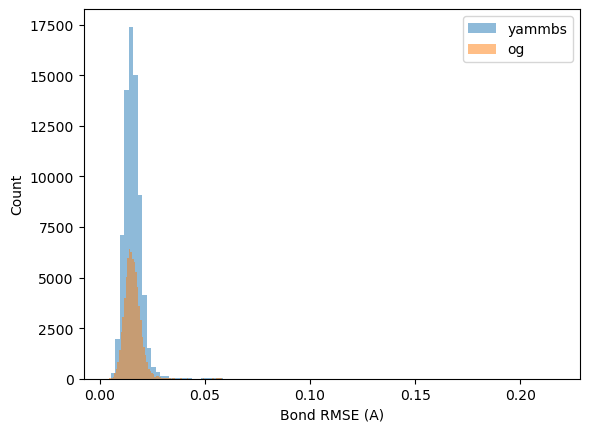

In [228]:
plt.figure()
plt.hist(yammbs_bondrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_bondrmsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('Bond RMSE (A)')
plt.ylabel('Count')
plt.savefig('figures/bondrmse_smiles.jpg')
plt.show()

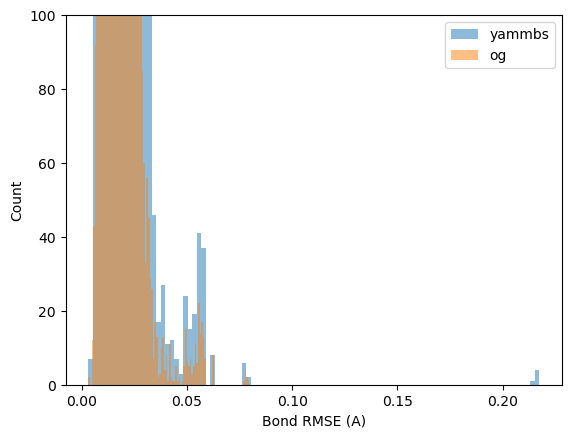

In [229]:
plt.figure()
plt.hist(yammbs_bondrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_bondrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Bond RMSE (A)')
plt.ylabel('Count')
plt.savefig('figures/bondrmse_smiles_zoom.jpg')
plt.show()

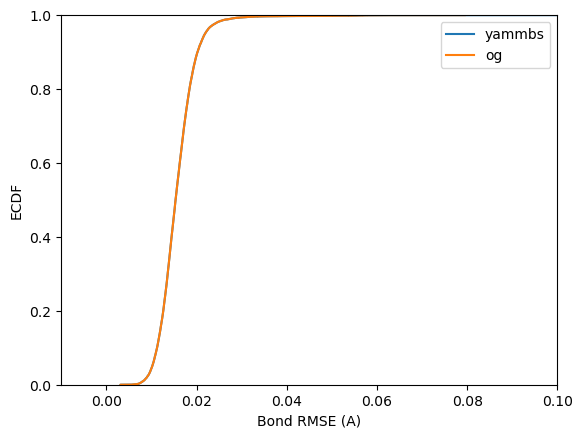

In [230]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_bondrmsd_inog.dropna()),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_bondrmsd_inym.dropna()['Bond RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-.01,0.1)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('Bond RMSE (A)')
plt.savefig('figures/bondrmse_smiles_ecdf.jpg')
plt.show()

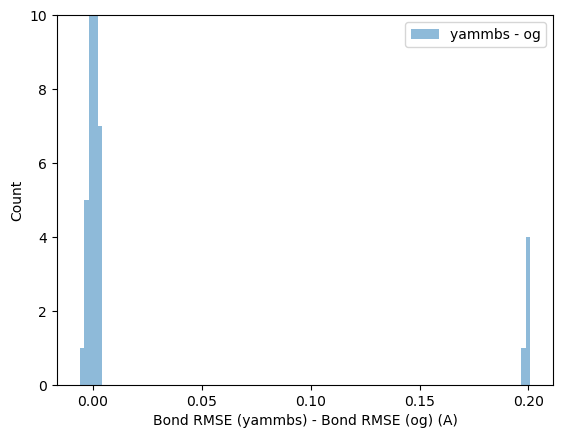

In [278]:
plt.figure()
plt.hist(yammbs_bondrmsd_inog.dropna() - sage_210_ogbm_bondrmsd_inym.dropna()['Bond RMSD'],label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_bondrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,10)
plt.legend()
plt.xlabel('Bond RMSE (yammbs) - Bond RMSE (og) (A)')
plt.ylabel('Count')
plt.savefig('figures/bondrmse_smiles_dif.jpg')
plt.show()

In [232]:
bond_rmsd_bigdif = (yammbs_bondrmsd_inog.dropna() - sage_210_ogbm_bondrmsd_inym.dropna()['Bond RMSD']).loc[np.abs(yammbs_bondrmsd_inog.dropna() - sage_210_ogbm_bondrmsd_inym.dropna()['Bond RMSD']) > 0.05]

### Examine some bad outliers

In [233]:
yammbs_bondrmsd_inog.loc[yammbs_bondrmsd_inog>0.2].sort_index()

Unnamed: 0
36966569    0.215219
36966572    0.217501
36966573    0.216297
36966574    0.216241
36966576    0.217270
Name: Bond, dtype: float64

In [234]:
sage_210_ogbm_bondrmsd_inym.loc[sage_210_ogbm_bondrmsd_inym.index.isin(list(yammbs_bondrmsd_inog.loc[yammbs_bondrmsd_inog>0.2].index))].sort_index()

,Bond RMSD
Record ID,
36966569,0.016909
36966572,0.016544
36966573,0.016571
36966574,0.016570
36966576,0.016574


In [235]:
yammbs_rmsd_inog.loc[yammbs_rmsd_inog.index.isin(list(yammbs_bondrmsd_inog.loc[yammbs_bondrmsd_inog>0.2].index))].sort_index()

,rmsd
Unnamed: 0,
36966569,0.848425
36966572,0.529652
36966573,0.541574
36966574,0.605960
36966576,0.616611


In [236]:
sage_210_ogbm_rmsd_inym.loc[sage_210_ogbm_rmsd_inym.index.isin(list(yammbs_bondrmsd_inog.loc[yammbs_bondrmsd_inog>0.2].index))].sort_index()

,RMSD
Record ID,
36966569,0.844976
36966572,0.608413
36966573,0.601009
36966574,0.593299
36966576,0.621872


In [237]:
# idx=int(icrmsds_bonds_inog.loc[icrmsds_bonds_inog>0.2].index[0])
idx = 36966572
idx

36966572

This file is too large to upload to github but I can share it upon request

In [23]:
store = MoleculeStore("../../sage-2.2.0/05_benchmark_forcefield_oldscript/openff_unconstrained-2.1.0.sqlite")

In [239]:
qm_gt2 = store.get_qm_conformer_by_qcarchive_id(idx)

In [240]:
mm_gt2 = store.get_mm_conformer_by_qcarchive_id(idx,'openff_unconstrained-2.1.0.offxml')

In [241]:
molid = store.get_molecule_id_by_qcarchive_id(idx)

In [242]:
smiles = store.get_smiles_by_molecule_id(molid)

In [243]:
mm_mol = Molecule.from_mapped_smiles(smiles)
mm_mol.add_conformer(unit.Quantity(mm_gt2,unit.angstrom))

1

In [244]:
mm_mol

NGLWidget()

In [245]:
qm_mol = Molecule.from_mapped_smiles(smiles)
qm_mol.add_conformer(unit.Quantity(qm_gt2,unit.angstrom))

1

In [246]:
qm_mol

NGLWidget()

Can't say too much about this without having the MM-optimized structure from the OG benchmark. But seems like they may have optimized to different structures, leading to a different bond RMSE.

## Angles

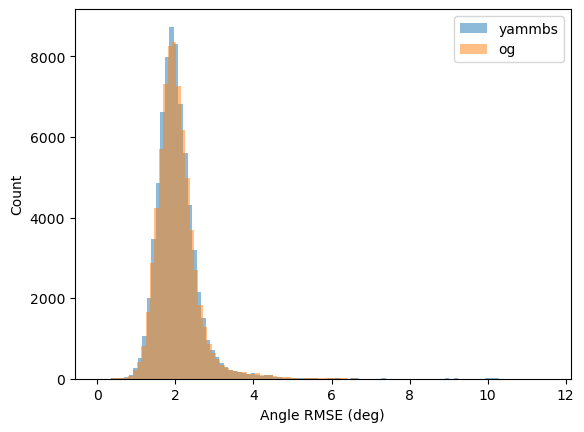

In [247]:
plt.figure()
plt.hist(yammbs_anglermsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_anglermsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('Angle RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/anglermse_smiles.jpg')
plt.show()

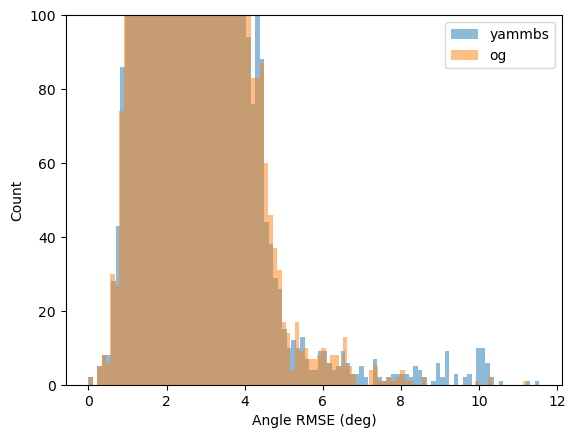

In [248]:
plt.figure()
plt.hist(yammbs_anglermsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_anglermsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Angle RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/anglermse_smiles_zoom.jpg')
plt.show()

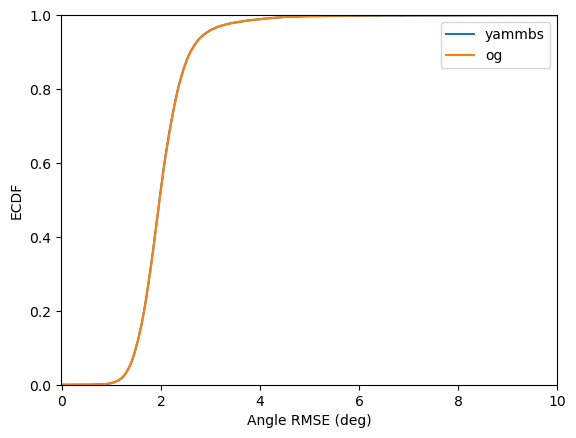

In [249]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_anglermsd_inog.dropna()),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_anglermsd_inym.dropna()['Angle RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-.01,10)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('Angle RMSE (deg)')
plt.savefig('figures/anglermse_smiles_ecdf.jpg')
plt.show()

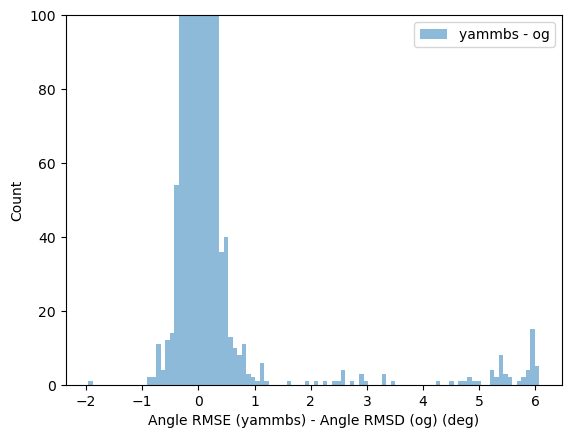

In [279]:
plt.figure()
plt.hist(yammbs_anglermsd_inog.dropna() - sage_210_ogbm_anglermsd_inym.dropna()['Angle RMSD'],label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_anglermsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Angle RMSE (yammbs) - Angle RMSD (og) (deg)')
plt.ylabel('Count')
plt.savefig('figures/anglermse_smiles_dif.jpg')
plt.show()

In [251]:
angle_rmsd_bigdif = (yammbs_anglermsd_inog.dropna() - sage_210_ogbm_anglermsd_inym.dropna()['Angle RMSD']).loc[np.abs(yammbs_anglermsd_inog.dropna() - sage_210_ogbm_anglermsd_inym.dropna()['Angle RMSD']) > 1]

### Examine some bad outliers

In [252]:
yammbs_gt9_og_lt9= yammbs_anglermsd_inog.loc[(yammbs_anglermsd_inog>9) & (sage_210_ogbm_anglermsd_inym['Angle RMSD'] < 9)].sort_index()
# yammbs_gt9_og_lt9

In [253]:
sage_210_ogbm_anglermsd_inym.loc[sage_210_ogbm_anglermsd_inym.index.isin(list(yammbs_gt9_og_lt9.index))].sort_index()['Angle RMSD'] -yammbs_gt9_og_lt9 

Record ID
36957544   -5.561158
36957546   -5.392203
36957548   -5.558792
36957552   -5.447740
36957824   -3.466008
36976597   -3.287863
36982891   -3.338562
36984866   -4.243221
36997513   -2.996564
37007562   -5.705886
37007579   -6.031294
37007580   -6.069537
37007581   -5.925552
37007582   -6.061781
37007583   -6.031419
37008017   -5.954566
37008018   -5.925396
37008019   -5.929476
37008020   -5.898935
37008021   -5.954515
37008022   -5.948350
37008023   -6.018713
37008024   -5.982432
37008025   -5.888928
37008183   -5.423158
37008184   -5.419026
37008185   -5.422233
37008394   -3.295302
37010393   -5.490457
37012742   -5.495992
37013608   -5.905641
37013609   -5.924201
37013610   -5.933481
37013611   -5.919252
37013612   -5.934192
37013613   -5.942494
37013614   -5.942980
37013615   -5.862487
37013616   -5.932252
37013617   -5.914536
37013817   -5.284184
37013818   -5.765038
37013819   -5.759476
37013822   -5.373601
37013823   -5.283871
37015507   -2.903721
dtype: float64

In [254]:
yammbs_gt9_rmsd = yammbs_rmsd_inog.loc[yammbs_rmsd_inog.index.isin(list(yammbs_gt9_og_lt9.index))].sort_index()

In [255]:
sage_gt9_rmsd = sage_210_ogbm_rmsd_inym.loc[sage_210_ogbm_rmsd_inym.index.isin(list(yammbs_gt9_og_lt9.index))].sort_index()
yammbs_gt9_rmsd['rmsd'] - sage_gt9_rmsd['RMSD']

Unnamed: 0
36957544   -0.269134
36957546   -0.179877
36957548   -0.010614
36957552   -0.291825
36957824   -0.783161
36976597   -0.398197
36982891   -0.451368
36984866   -0.343952
36997513   -0.585550
37007562   -0.248863
37007579   -0.235667
37007580   -0.208068
37007581   -0.183468
37007582   -0.212485
37007583   -0.236015
37008017   -0.266896
37008018   -0.135740
37008019   -0.316254
37008020   -0.208753
37008021   -0.243906
37008022   -0.278553
37008023   -0.232428
37008024   -0.211069
37008025   -0.194536
37008183   -0.217663
37008184   -0.217594
37008185   -0.229798
37008394   -0.569159
37010393   -0.234270
37012742   -0.203964
37013608   -0.221844
37013609   -0.198890
37013610   -0.283901
37013611   -0.232673
37013612   -0.203924
37013613   -0.206144
37013614   -0.237436
37013615   -0.182940
37013616   -0.246878
37013617   -0.209243
37013817   -0.094384
37013818   -0.216700
37013819   -0.216194
37013822   -0.278608
37013823   -0.094329
37015507   -0.092365
dtype: float64

In [256]:
# idx=int(icrmsds_bonds_inog.loc[icrmsds_bonds_inog>0.2].index[0])
idx = 36957824
idx

36957824

In [257]:
qm_gt2 = store.get_qm_conformer_by_qcarchive_id(idx)

In [258]:
mm_gt2 = store.get_mm_conformer_by_qcarchive_id(idx,'openff_unconstrained-2.1.0.offxml')

In [259]:
molid = store.get_molecule_id_by_qcarchive_id(idx)

In [260]:
smiles = store.get_smiles_by_molecule_id(molid)

In [261]:
mm_mol = Molecule.from_mapped_smiles(smiles,allow_undefined_stereo=True)
mm_mol.add_conformer(unit.Quantity(mm_gt2,unit.angstrom))

1

In [262]:
mm_mol

NGLWidget()

In [263]:
qm_mol = Molecule.from_mapped_smiles(smiles,allow_undefined_stereo=True)
qm_mol.add_conformer(unit.Quantity(qm_gt2,unit.angstrom))

1

In [264]:
qm_mol

NGLWidget()

There are large RMSD differences between the YAMMBS outliers and their OG counterparts. Makes me think they've optimized to different structures

## Dihedrals

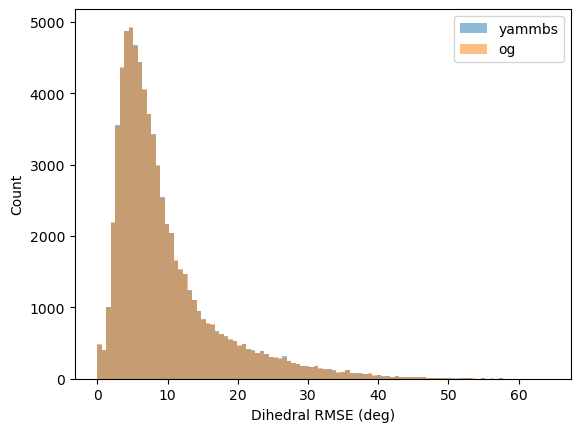

In [265]:
plt.figure()
plt.hist(yammbs_dihedralrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_dihedralrmsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('Dihedral RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/dihedralrmse_smiles.jpg')
plt.show()

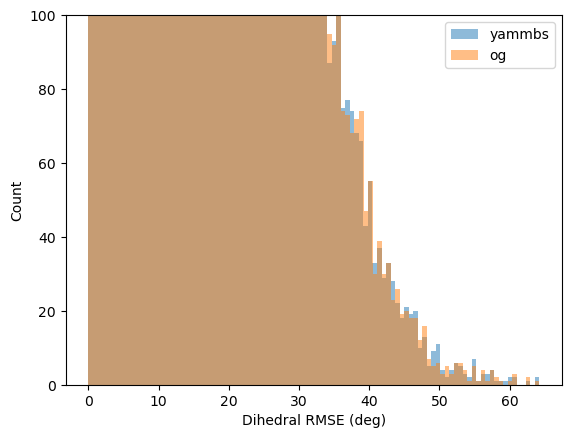

In [266]:
plt.figure()
plt.hist(yammbs_dihedralrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_dihedralrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Dihedral RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/dihedralrmse_smiles_zoom.jpg')
plt.show()

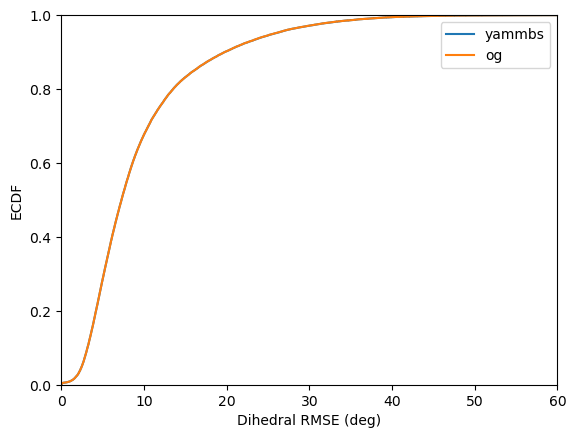

In [267]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_dihedralrmsd_inog.dropna()),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_dihedralrmsd_inym.dropna()['Dihedral RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-.01,60)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('Dihedral RMSE (deg)')
plt.savefig('figures/dihedralrmse_smiles_ecdf.jpg')
plt.show()

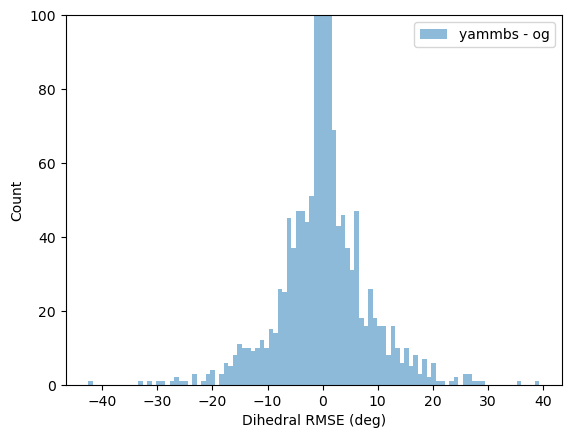

In [280]:
plt.figure()
plt.hist(yammbs_dihedralrmsd_inog.dropna()-sage_210_ogbm_dihedralrmsd_inym.dropna()['Dihedral RMSD'],label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_dihedralrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Dihedral RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/dihedralrmse_smiles_dif.jpg')
plt.show()

In [269]:
dihedral_rmsd_bigdif = (yammbs_dihedralrmsd_inog.dropna()-sage_210_ogbm_dihedralrmsd_inym.dropna()['Dihedral RMSD']).loc[np.abs(yammbs_dihedralrmsd_inog.dropna()-sage_210_ogbm_dihedralrmsd_inym.dropna()['Dihedral RMSD'])>10]

## Improper

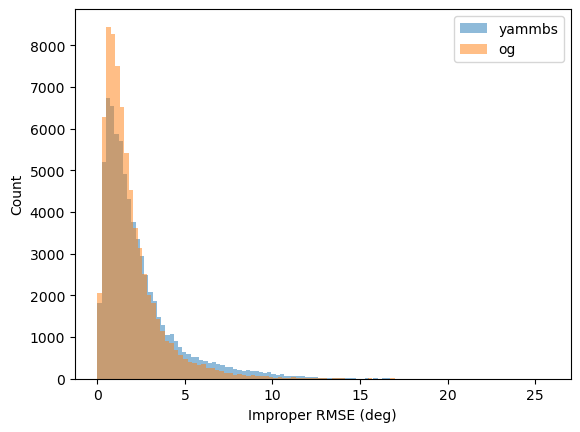

In [270]:
plt.figure()
plt.hist(yammbs_improperrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_improperrmsd_inym,label='og',alpha=0.5,bins=100)
# plt.ylim(0,100)
plt.legend()
plt.xlabel('Improper RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/improperrmse_smiles.jpg')
plt.show()

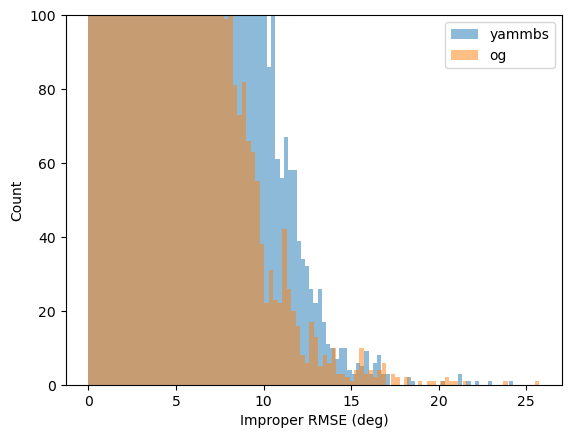

In [271]:
plt.figure()
plt.hist(yammbs_improperrmsd_inog,label='yammbs',alpha=0.5,bins=100)
plt.hist(sage_210_ogbm_improperrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Improper RMSE (deg)')
plt.ylabel('Count')
plt.savefig('figures/improperrmse_smiles_zoom.jpg')
plt.show()

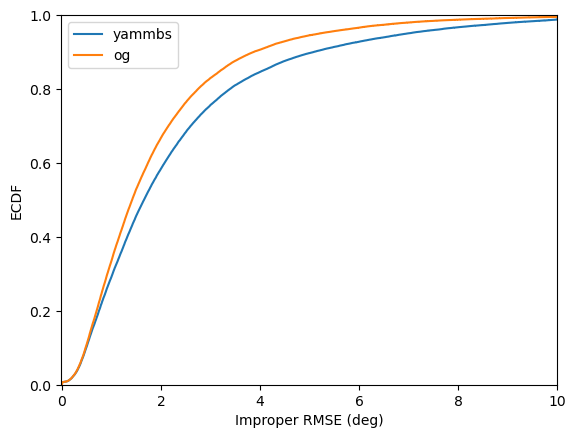

In [272]:
fig,ax = plt.subplots(1)
ax.ecdf(np.abs(yammbs_improperrmsd_inog.dropna()),label='yammbs')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
ax.ecdf(np.abs(sage_210_ogbm_improperrmsd_inym.dropna()['Improper RMSD']),label='og')#,alpha=0.5,bins=100,cumulative=True,histtype='step')
# plt.ylim(0,100)
ax.set_xlim(-.01,10)
ax.legend()
ax.set_ylabel('ECDF')
ax.set_xlabel('Improper RMSE (deg)')
plt.savefig('figures/improperrmse_smiles_ecdf.jpg')
plt.show()

Impropers are really off, not sure why...YAMMBS steals code from force balance for this, whereas the OG bm just uses the conventional RMSD. Could be an issue with periodicity, but that would be an issue with dihedrals too I'd think. Unless it's somehow taken care of in the generation?

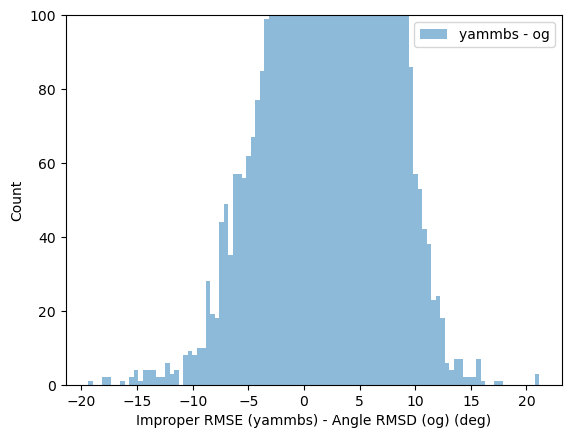

In [282]:
plt.figure()
plt.hist(yammbs_improperrmsd_inog.dropna() - sage_210_ogbm_improperrmsd_inym.dropna()['Improper RMSD'],label='yammbs - og',alpha=0.5,bins=100)
# plt.hist(sage_210_ogbm_improperrmsd_inym,label='og',alpha=0.5,bins=100)
plt.ylim(0,100)
plt.legend()
plt.xlabel('Improper RMSE (yammbs) - Angle RMSD (og) (deg)')
plt.ylabel('Count')
plt.savefig('figures/improperrmse_smiles_dif.jpg')
plt.show()

In [274]:
improper_rmsd_bigdif = (yammbs_improperrmsd_inog.dropna() - sage_210_ogbm_improperrmsd_inym.dropna()['Improper RMSD']).loc[np.abs(yammbs_improperrmsd_inog.dropna() - sage_210_ogbm_improperrmsd_inym.dropna()['Improper RMSD'])>10]

In [286]:
print('DDE big dif',dde_bigdif.shape[0])
print('RMSD big dif',rmsd_bigdif.shape[0])
print('TFD big dif',tfd_bigdif.shape[0])
print('Bond big dif',bond_rmsd_bigdif.shape[0])
print('Angle big dif',angle_rmsd_bigdif.shape[0])
print('Dihedral big dif',dihedral_rmsd_bigdif.shape[0])
print('Improper big dif',improper_rmsd_bigdif.shape[0])
print()

print('Overlap DDE/RMSD',rmsd_bigdif.loc[rmsd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])
print('Overlap DDE/TFD',tfd_bigdif.loc[tfd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])
print('Overlap RMSD/TFD',rmsd_bigdif.loc[rmsd_bigdif.index.isin(list(tfd_bigdif.index))].shape[0])

print('Overlap DDE/bond',bond_rmsd_bigdif.loc[bond_rmsd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])
print('Overlap DDE/angle',angle_rmsd_bigdif.loc[angle_rmsd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])
print('Overlap DDE/proper',dihedral_rmsd_bigdif.loc[dihedral_rmsd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])
print('Overlap DDE/improper',improper_rmsd_bigdif.loc[improper_rmsd_bigdif.index.isin(list(dde_bigdif.index))].shape[0])

print('Overlap RMSD/bond',bond_rmsd_bigdif.loc[bond_rmsd_bigdif.index.isin(list(rmsd_bigdif.index))].shape[0])
print('Overlap RMSD/angle',angle_rmsd_bigdif.loc[angle_rmsd_bigdif.index.isin(list(rmsd_bigdif.index))].shape[0])
print('Overlap RMSD/proper',dihedral_rmsd_bigdif.loc[dihedral_rmsd_bigdif.index.isin(list(rmsd_bigdif.index))].shape[0])
print('Overlap RMSD/improper',improper_rmsd_bigdif.loc[improper_rmsd_bigdif.index.isin(list(rmsd_bigdif.index))].shape[0])

print('Overlap TFD/bond',bond_rmsd_bigdif.loc[bond_rmsd_bigdif.index.isin(list(tfd_bigdif.index))].shape[0])
print('Overlap TFD/angle',angle_rmsd_bigdif.loc[angle_rmsd_bigdif.index.isin(list(tfd_bigdif.index))].shape[0])
print('Overlap TFD/proper',dihedral_rmsd_bigdif.loc[dihedral_rmsd_bigdif.index.isin(list(tfd_bigdif.index))].shape[0])
print('Overlap TFD/improper',improper_rmsd_bigdif.loc[improper_rmsd_bigdif.index.isin(list(tfd_bigdif.index))].shape[0])


DDE big dif 564
RMSD big dif 222
TFD big dif 56
Bond big dif 5
Angle big dif 82
Dihedral big dif 239
Improper big dif 332

Overlap DDE/RMSD 36
Overlap DDE/TFD 10
Overlap RMSD/TFD 29
Overlap DDE/bond 0
Overlap DDE/angle 0
Overlap DDE/proper 44
Overlap DDE/improper 4
Overlap RMSD/bond 0
Overlap RMSD/angle 1
Overlap RMSD/proper 106
Overlap RMSD/improper 5
Overlap TFD/bond 0
Overlap TFD/angle 0
Overlap TFD/proper 22
Overlap TFD/improper 2


Mostly non-overlapping differences...